#                                              利用奇异值分解(SVD)
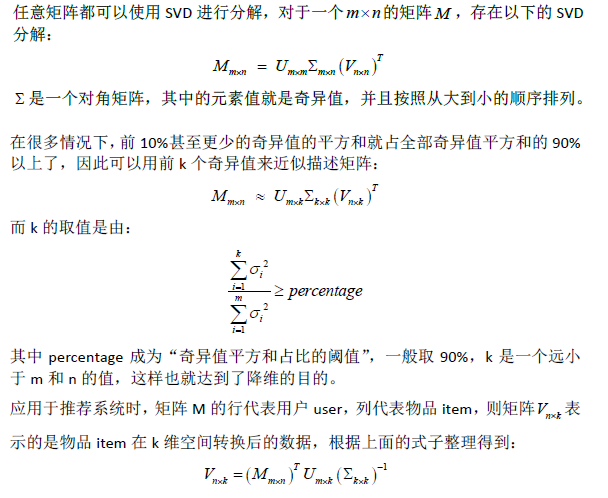

In [28]:
import numpy as np
from numpy import linalg as la

#读取数据，根据原始数据填充原始评分矩阵
def get_data(path,user=None,item=None):
    if user==None or item==None:        
        with open(path, "rb") as f:
            users = 0 #user的数量
            items = 0 #item的数量
            for line in f:
                temp = line.decode().split("\t")
                user_id,item_id,rating = int(temp[0]),int(temp[1]),int(temp[2])
                if user_id > users:
                    users = user_id
                if item_id > items:
                    items = item_id
    else:
        users = user
        items = item  
    #全零初始化评分矩阵               
    matrix = np.zeros((users,items)) 
    with open(path, "rb") as f:
        for line in f:
            temp = line.decode().split("\t")
            user_id,item_id,rating = int(temp[0]),int(temp[1]),int(temp[2])
            matrix[user_id-1][item_id-1] = rating
        return matrix,users,items

# 计算潜在特征数k
def get_k(Sigma,percentage): 
    sigma2 = Sigma**2 #对Sigma求平方
    sumsgm2 = np.sum(sigma2) #求所有奇异值Sigma的平方和
    sumsgm2_k = 0 #sumsgm2_k是前k个奇异值的平方和
    k = 0
    for i in range(0,Sigma.size):
        sumsgm2_k += i**2
        k += 1
        if sumsgm2_k >= sumsgm2*percentage:
            return k   

#根据K值将矩阵降维
def reduce_diemonsin(U,VT,k):
    m = U.shape[0]
    n = VT.shape[1]
    P = np.zeros((m,k))
    T = np.zeros((n,k))
    Q = np.zeros((k,n))
    for i in range(0,m):
        for j in range(0,k):
            P[i][j]=U[i][j]
    for i in range(0,n):
        for j in range(0,k):
            T[i][j]=VT[i][j]
    Q = T.transpose()
    return P,Q

#验证
def vaild(train_data,test_data,users,items,penalty_factor=0.01):
    U,Sigma,VT = la.svd(train_data)
    k = get_k(Sigma,0.9)
    P,Q = reduce_diemonsin(U,VT,k)
    loss = np.sum(np.power(test_data-np.dot(P,Q),2))/(users*items)+penalty_factor*(np.sum(np.power(P,2))+np.sum(np.power(Q,2)))/k
    return loss
    
if __name__ == "__main__":
    train_data,users,items = get_data("ml-100k/u1.base")
    test_data,users,items = get_data("ml-100k/u1.test",users,items)
    loss1 = vaild(train_data,test_data,users,items,penalty_factor=0.01)
    print("Loss of validation set \'u1.test\':",loss1)
    train_data,users,items = get_data("ml-100k/u2.base")
    test_data,users,items = get_data("ml-100k/u2.test",users,items)
    loss2 = vaild(train_data,test_data,users,items,penalty_factor=0.01)
    print("Loss of validation set \'u2.test\':",loss2)
    train_data,users,items = get_data("ml-100k/u3.base")
    test_data,users,items = get_data("ml-100k/u3.test",users,items)
    loss3 = vaild(train_data,test_data,users,items,penalty_factor=0.01)
    print("Loss of validation set \'u3.test\':",loss3)
    train_data,users,items = get_data("ml-100k/u4.base")
    test_data,users,items = get_data("ml-100k/u4.test",users,items)
    loss4 = vaild(train_data,test_data,users,items,penalty_factor=0.01)
    print("Loss of validation set \'u4.test\':",loss4)
    print("--------------------------------------------------------")
    print("\n")


Loss of validation set 'u1.test': 0.194532227522
Loss of validation set 'u2.test': 0.194543605166
Loss of validation set 'u3.test': 0.192372269294
Loss of validation set 'u4.test': 0.192136987786
--------------------------------------------------------




# 利用交替最小二乘法（ALS）分解
## ALS algorithm
- Loss function: $L_{u,i}=(r_{u,i}-\sum_{k=1}^K p_{u,k}q_{k,i})^2+\lambda(\|\mathbf{P}\|^2+\|\mathbf{Q}\|^2)$
- Gradient: $\left\{ \begin{array}{rl} \frac{\partial L_{u,i}}{\partial p_{u,k}}=-2(r_{u,i}-\sum_{k=1}^K p_{u,k}q_{k,i})\cdot q_{k,i}+2\lambda\cdot p_{u,k} \\ 
                                                             \frac{\partial L_{u,i}}{\partial q_{k,i}}=-2(r_{u,i}-\sum_{k=1}^K p_{u,k}q_{k,i})\cdot p_{u,k}+2\lambda\cdot q_{k,i}
                                \end{array} \right. $
- Update: $\left\{ \begin{array}{rl} p_{u,k}\gets p_{u,k}+\eta\cdot\frac{\partial L_{u,i}}{\partial p_{u,k}} \\
                                                           p_{k,i}\gets q_{k,i}+\eta\cdot\frac{\partial L_{u,i}}{\partial q_{k,i}}
                                \end{array} \right. $

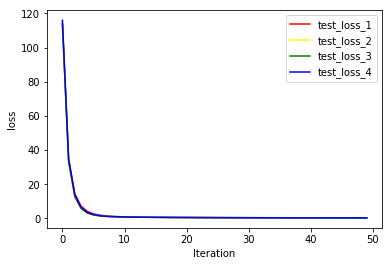

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#读取数据，根据原始数据填充原始评分矩阵
def get_data(path,user=None,item=None):
    if user==None or item==None:        
        with open(path, "rb") as f:
            users = 0 #user的数量
            items = 0 #item的数量
            for line in f:
                temp = line.decode().split("\t")
                user_id,item_id,rating = int(temp[0]),int(temp[1]),int(temp[2])
                if user_id > users:
                    users = user_id
                if item_id > items:
                    items = item_id
    else:
        users = user
        items = item   
    #全零初始化评分矩阵               
    matrix = np.zeros((users,items)) 
    with open(path, "rb") as f:
        for line in f:
            temp = line.decode().split("\t")
            user_id,item_id,rating = int(temp[0]),int(temp[1]),int(temp[2])
            matrix[user_id-1][item_id-1] = rating
        return matrix,users,items   

#利用交替最小二乘法优化
def train_and_test(train_data,test_data,k,penalty_factor=0.01,learning_rate=0.0001,epochs=50):
    users = np.shape(train_data)[0]
    items = np.shape(train_data)[1]
    P = np.random.rand(users,k)
    Q = np.random.rand(k,items)
    L = []
    for step in range (epochs):
        #训练P矩阵和Q矩阵
        for u in range (users):
            for i in range (items):
                if train_data[u][i] > 0:
                    error = train_data[u][i]-np.dot(P[u],Q[:,i])
                    P[u] += 2*learning_rate*error*Q[:,i]-2*penalty_factor*P[u]
                    Q[:,i] += 2*learning_rate*error*P[u]-2*penalty_factor*Q[:,i]
        loss = np.sum(np.power(test_data-np.dot(P,Q),2))/(users*items) + penalty_factor*(np.sum(np.power(P,2))+np.sum(np.power(Q,2)))/k
        L.append(loss)
    return L

#画图
def plot_loss(loss):   
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.plot(loss, label="test_loss",color="red",linewidth=1.5)
    plt.legend(loc='upper right')
    plt.show()

def plot(loss1,loss2,loss3,loss4):   
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.plot(loss1, label="test_loss_1",color="red",linewidth=1.5)
    plt.plot(loss2, label="test_loss_2",color="yellow",linewidth=1.5)
    plt.plot(loss3, label="test_loss_3",color="green",linewidth=1.5)
    plt.plot(loss4, label="test_loss_4",color="blue",linewidth=1.5)
    plt.legend(loc='upper right')
    plt.show()
    
if __name__ == "__main__":
    k = 150
    train_1,users,items = get_data("ml-100k/u1.base")
    test_1,users,items = get_data("ml-100k/u1.test",users,items)   
    loss1 = train_and_test(train_1,test_1,k)
    #train_2,users,items = get_data("ml-100k/u2.base")
    #test_2,users,items = get_data("ml-100k/u2.test",users,items)   
    #loss2 = train_and_test(train_2,test_2,k)
    #train_3,users,items = get_data("ml-100k/u3.base")
    #test_3,users,items = get_data("ml-100k/u3.test",users,items)   
    #loss3 = train_and_test(train_3,test_3,k)
    #train_4,users,items = get_data("ml-100k/u4.base")
    #test_4,users,items = get_data("ml-100k/u4.test",users,items)   
    #loss4 = train_and_test(train_4,test_4,k)
    plot_loss(loss1)
    #plot(loss1,loss2,loss3,loss4)
    